# Introduction

The purpose of this project is to analyze nighttime aircraft noise complaints around San Francisco International Airport (SFO) to understand which neighborhoods are most affected. Specifically, we aim to:

Identify neighborhoods with the highest number of night-time complaints (8 PM–7 AM).

Examine how factors such as aircraft type, altitude, and operation type influence complaint patterns.

Build a predictive model to estimate future complaint levels and test how changes in flight operations could reduce noise.

By cleaning, analyzing, and modeling aircraft noise data from SFO, this project seeks to uncover meaningful insights that can help both residents and airport authorities address nighttime noise disturbances.

# Data Source

The dataset used in this project is the San Francisco International Airport (SFO) Aircraft Noise Reports, obtained from Data.gov :  https://catalog.data.gov/dataset/sfo-aircraft-noise-reports
. It contains aircraft noise complaints recorded by residents near SFO from 2018 to the present.

For this analysis, we focus only on night-time reports (8 PM–7 AM). The dataset includes variables such as disturbance date and time, reporter city and postal code, aircraft altitude, aircraft type, operation type, and airport ID, hour. Some cleaning was performed to remove missing values, filter SFO records, and ensure data consistency.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [11]:
# Download latest version of your dataset
df = pd.read_csv("../data/Aircraft_Noise_Reports.csv")

# inspect dataset
df.shape
df.head()
df.info()

/var/folders/wx/0m6_v4n9285892l822ksy8740000gn/T/ipykernel_82781/2294344268.py:2: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/Aircraft_Noise_Reports.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6960960 entries, 0 to 6960959
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   disturbance_date_time  object 
 1   report_method          object 
 2   corr_id                int64  
 3   reporter_city          object 
 4   reporter_postal_code   object 
 5   aircraft_pca_altitude  float64
 6   airport_id             object 
 7   operation_type         object 
 8   runway_name            object 
 9   flight_no              object 
 10  aircraft_type          object 
 11  destination_origin     object 
 12  data_as_of             object 
 13  data_loaded_at         object 
dtypes: float64(1), int64(1), object(12)
memory usage: 743.5+ MB


# Clean and Prepare Data

In [12]:

# Load only needed columns from the CSV to save memory
columns_to_load = [
    'disturbance_date_time', 'reporter_city', 'reporter_postal_code',
    'aircraft_pca_altitude', 'airport_id', 'operation_type', 'aircraft_type'
]


In [13]:

# Step 1: Drop rows with missing values in essential columns first
essential_columns = ['disturbance_date_time', 'reporter_postal_code', 'airport_id', 'operation_type']
df = df.dropna(subset=essential_columns)


In [14]:

# Step 2: Filter for SFO airport and operation type (Arrival/Departure)
df = df[(df['airport_id'] == 'SFO') & (df['operation_type'].isin(['A', 'D']))]


In [16]:

# Step 3: Convert disturbance_date_time to datetime (after dropping nulls to save time)

df['disturbance_date_time'] = pd.to_datetime(
    df['disturbance_date_time'],
    format="%Y/%m/%d %I:%M:%S %p",  # note %I for 12-hour and %p for AM/PM
    errors='coerce'
)


In [17]:

# Step 4: Drop rows where conversion failed (NaT values)
df = df.dropna(subset=['disturbance_date_time'])


In [18]:

# Step 5: Extract hour for night-time filtering
df['hour'] = df['disturbance_date_time'].dt.hour


In [19]:

# Step 6: Filter for night-time complaints (8 PM - 7 AM)
df = df[(df['hour'] >= 20) | (df['hour'] <= 7)]

# Remove duplicates
df = df.drop_duplicates()

# Step 7: Reset index
df = df.reset_index(drop=True)


In [20]:
# keep only the needed columns
columns_needed = [
    'disturbance_date_time', 'reporter_city', 'reporter_postal_code',
    'aircraft_pca_altitude', 'airport_id', 'operation_type', 'aircraft_type', 'hour'
]

df = df[columns_needed]

In [21]:
# Save the cleaned dataset
df.to_csv("../data/Cleaned_Aircraft_Noise_Night_SFO.csv", index=False)

print("Cleaned dataset saved to data/Cleaned_Aircraft_Noise_Night_SFO.csv")

Cleaned dataset saved to data/Cleaned_Aircraft_Noise_Night_SFO.csv


In [22]:
df.head()

,disturbance_date_time,reporter_city,reporter_postal_code,aircraft_pca_altitude,airport_id,operation_type,aircraft_type,hour
0,2024-08-18 20:03:17,Portola Valley,94028,5007.0,SFO,D,B77W,20
1,2024-08-18 20:13:19,Los Altos Hills,94024,6644.0,SFO,A,E75L,20
2,2024-08-18 20:12:53,Mountain View,94040,6296.0,SFO,A,E75L,20
3,2024-08-18 20:10:30,San Francisco,94124,4678.0,SFO,D,B738,20
4,2024-08-18 20:15:16,Mountain View,94040,6296.0,SFO,A,E75L,20


# Exploratory Data Analysis

In [23]:
print("\nNumeric Summary (aircraft_pca_altitude):\n", df['aircraft_pca_altitude'].describe())

print("\nCategorical Summary:")
print("\nOperation type counts:\n", df['operation_type'].value_counts())
print("\nAircraft type counts:\n", df['aircraft_type'].value_counts())
print("\nReporter city counts:\n", df['reporter_city'].value_counts())



Numeric Summary (aircraft_pca_altitude):
 count    2.025437e+06
mean     6.589694e+03
std      3.061845e+03
min     -5.710000e+02
25%      4.675000e+03
50%      5.784000e+03
75%      9.127000e+03
max      1.959000e+04
Name: aircraft_pca_altitude, dtype: float64

Categorical Summary:

Operation type counts:
 operation_type
A    1796897
D     229001
Name: count, dtype: int64

Aircraft type counts:
 aircraft_type
E75L     253748
B738     249753
A320     240616
B739     180945
B77W     112360
          ...  
PA32          1
C425          1
B722          1
AS350         1
B735          1
Name: count, Length: 203, dtype: int64

Reporter city counts:
 reporter_city
Palo Alto         539153
Portola Valley    277261
Santa Cruz        217696
Los Altos         207734
Scotts Valley     110485
                   ...  
Forest Knolls          2
Piedmont               1
Sf                     1
Colma                  1
Walnut Creek           1
Name: count, Length: 73, dtype: int64


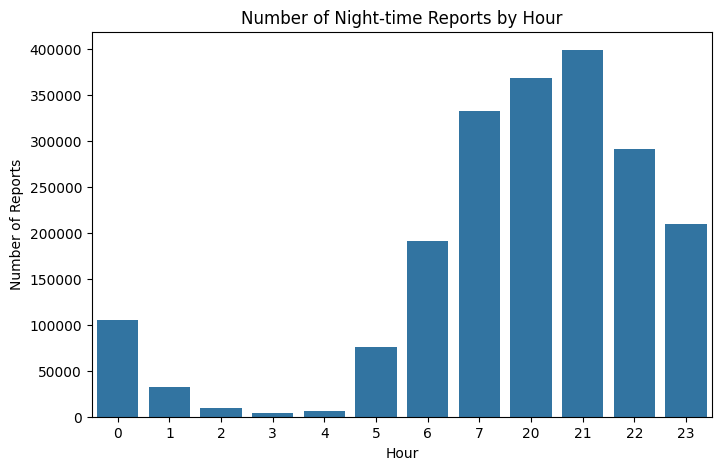

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='hour',data=df)
plt.title('Number of Night-time Reports by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Reports')
plt.show()

The number of night-time noise reports peaks between 8 PM and 10 PM, with the highest activity around 9 PM (Hour 21). Report counts drop sharply after midnight, reaching their lowest levels between 2 AM and 4 AM. Activity begins to rise again around 5 AM, showing a clear evening peak and early-morning lull pattern.

                           hour  aircraft_pca_altitude
hour                   1.000000               0.034875
aircraft_pca_altitude  0.034875               1.000000


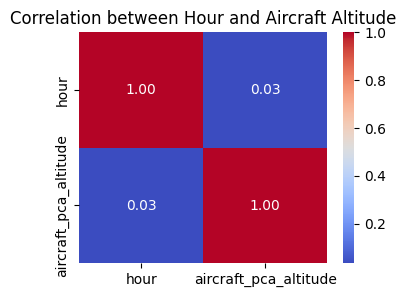

In [ ]:
# Correlation between hour and altitude
corr = df[['hour', 'aircraft_pca_altitude']].corr()
print(corr)

# Visualize the correlation
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Hour and Aircraft Altitude')
plt.show()

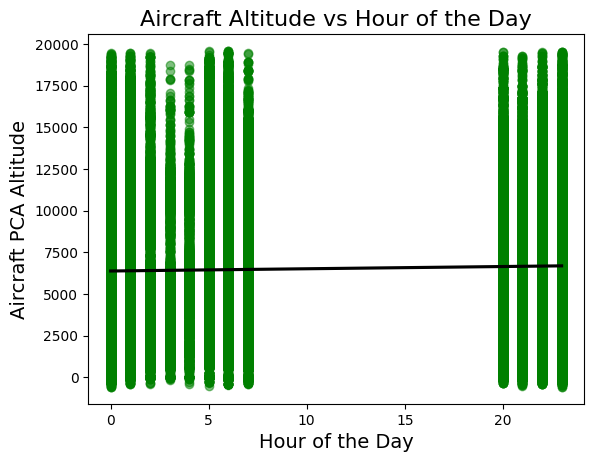

In [31]:
#Median Household Income vs. ACT Average:
sns.regplot(
    x='hour', 
    y='aircraft_pca_altitude', 
    data=df, 
    scatter_kws={'alpha':0.5, 'color': 'green'}, 
    line_kws={'color': 'black'}
)
plt.title('Aircraft Altitude vs Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Aircraft PCA Altitude', fontsize=14)
plt.show()